# Covid-19 data analysis for the Netherland
## uses covid data to learn datascience in pyhton woth Jupyterlab

*Goals*
1. learning datawcience
2. learning python
3. learning Jupyterlab
4. maybe get some insight in covid

In [ ]:
## install modules for Google Colab
# uncomment line below and run cell
#!pip install tabula-py cbsodata

In [1]:
#from IPython.display import Markdown as md
#import numpy as np
import pandas as pd
import tabula
from datetime import datetime
#import json

import cbsodata as cbs

## Revert to charts in pandas, for simplicity. 
#To DO: add Bokeh - https://docs.bokeh.org/
#from bokeh.io import output_notebook
#from bokeh.plotting import figure, show
#from bokeh.palettes import viridis
#import pandas_bokeh
#output_notebook()

## Preparing dataframe

In [2]:
#full_df = pd.DataFrame(index=pd.MultiIndex(levels=[pd.PeriodIndex(pd.date_range('1-1-2000',periods=21*365.25),freq='M'),pd.PeriodIndex(pd.date_range('1-1-2000',periods=21*365.25),freq='D')],names=['Period','Day']))

## Collecting data

### CBS
https://opendata.cbs.nl/statline/portal.html

In [3]:
print('Importing: Bevolkingsontwikkeling; maand en jaar 2002-now (Population statistics, month and year)')
population = pd.DataFrame(cbs.get_data('37230ned'))
print('DONE')

Importing: Bevolkingsontwikkeling; maand en jaar 2002-now (Population statistics, month and year)
DONE


In [4]:
print('Preparing Dataframe for analyses')
print('Dropping unnecessary columns')
population = population.drop(columns=['ID', 'BevolkingAanHetBeginVanDePeriode_1','TotaleVestiging_4',
       'VestigingVanuitEenAndereGemeente_5', 'Immigratie_6',
       'TotaalVertrekInclAdmCorrecties_7', 'VertrekNaarAndereGemeente_8',
       'EmigratieInclusiefAdmCorrecties_9', 'OverigeCorrecties_10',
       'Bevolkingsgroei_11', 'BevolkingsgroeiRelatief_12',
       'BevolkingsgroeiSinds1Januari_13',
       'BevolkingsgroeiSinds1JanuariRela_14'])
population = population.rename(columns={"LevendGeborenKinderen_2": "Born", "Overledenen_3": "Deceased", "BevolkingAanHetEindeVanDePeriode_15": "Population"})
print('DONE')

Preparing Dataframe for analyses
Dropping unnecessary columns
DONE


In [5]:
# defining function for calculating percentage
def percentage(df,d,n):
    df[d+'_perc'] = df[d]/df[n]*100

In [ ]:
print('Calculating percentage deceased of population')
percentage(population,'Deceased','Population')
print('DONE')

Calculating percentage deceased of population
DONE


In [6]:
print('Setting Period')
population['year'] = population.loc[:,'Perioden'].str.slice(stop=4)
population['month'] = population.loc[:,'Perioden'].str.slice(start=5)
population = population.loc[population['month'] != '',:]
population['month'] = population.loc[:,'month'].replace({
    'januari': '01',
    'februari': '02',
    'maart': '03',
    'april': '04',
    'mei': '05',
    'juni': '06',
    'juli': '07',
    'augustus': '08',
    'september': '09',
    'oktober': '10',
    'november': '11',
    'december': '12'})



Setting Period


In [ ]:
population = population.set_index(population['year'] + '-' + population['month'])
population.index = pd.PeriodIndex(population.index, freq='M')

#population.index = pd.to_datetime(population.index, yearfirst=True)
#population.index = population.index.date

In [ ]:
print(population[['year','month']])

         year month
2002-01  2002    01
2002-02  2002    02
2002-03  2002    03
2002-04  2002    04
2002-05  2002    05
...       ...   ...
2020-05  2020    05
2020-06  2020    06
2020-07  2020    07
2020-08  2020    08
2020-09  2020    09

[136800 rows x 2 columns]


In [ ]:
print('Ceating dataframe for Nederland')
population_nl = population[population['RegioS'] == 'Nederland']
#population_nl = population_nl.set_index(population_nl['Period'])
#population_nl.index = pd.PeriodIndex(population_nl.index, freq = 'M')
#population_nl = population_nl.rename(columns={'Period':'P'})
#population = population[population['RegioS'] != 'Nederland']
print('DONE')

Ceating dataframe for Nederland
DONE


In [ ]:
population_nl

,RegioS,Perioden,Born,Deceased,Population,Deceased_perc,year,month
0,Nederland,2002 januari,17019.0,13469.0,16112900.0,0.083591,2002,01
1,Nederland,2002 februari,15448.0,11735.0,16118953.0,0.072802,2002,02
2,Nederland,2002 maart,16792.0,13281.0,16124125.0,0.082367,2002,03
3,Nederland,2002 april,15995.0,11968.0,16130246.0,0.074196,2002,04
4,Nederland,2002 mei,16800.0,11623.0,16136807.0,0.072028,2002,05
...,...,...,...,...,...,...,...,...
238,Nederland,2020 mei,13731.0,12616.0,17418808.0,0.072427,2020,05
239,Nederland,2020 juni,13894.0,11486.0,17422478.0,0.065926,2020,06
240,Nederland,2020 juli,15572.0,11615.0,17427806.0,0.066646,2020,07
241,Nederland,2020 augustus,15065.0,12533.0,17440679.0,0.071861,2020,08


In [ ]:
populationx = population_nl
populationx = populationx.set_index(population_nl['year'] + '-' + population_nl['month'] + '-01')
populationx.index = pd.to_datetime(populationx.index) + pd.offsets.MonthEnd()
populationx.index = pd.DatetimeIndex(populationx.index)
populationx.index = populationx.index.to_period(freq='M')


#populationx['Period'] = population_nl['year'] + '-' + population_nl['month'] + '-01'
#populationx['Period'] = pd.to_datetime(populationx['Period'],format="%Y-%m-%d") + pd.offsets.MonthEnd()
#populationx = populationx.set_index(pd.DatetimeIndex(populationx['Period']))
#populationx.index = populationx.index.to_period(freq='M')

In [ ]:
print(populationx)

            RegioS        Perioden     Born  Deceased  Population  \
2002-01  Nederland    2002 januari  17019.0   13469.0  16112900.0   
2002-02  Nederland   2002 februari  15448.0   11735.0  16118953.0   
2002-03  Nederland      2002 maart  16792.0   13281.0  16124125.0   
2002-04  Nederland      2002 april  15995.0   11968.0  16130246.0   
2002-05  Nederland        2002 mei  16800.0   11623.0  16136807.0   
...            ...             ...      ...       ...         ...   
2020-05  Nederland        2020 mei  13731.0   12616.0  17418808.0   
2020-06  Nederland       2020 juni  13894.0   11486.0  17422478.0   
2020-07  Nederland       2020 juli  15572.0   11615.0  17427806.0   
2020-08  Nederland   2020 augustus  15065.0   12533.0  17440679.0   
2020-09  Nederland  2020 september  14914.0   11921.0  17461543.0   

         Deceased_perc  year month  
2002-01       0.083591  2002    01  
2002-02       0.072802  2002    02  
2002-03       0.082367  2002    03  
2002-04       0.074196 

In [ ]:




#population = population.set_index(population['Period'])
#population = population.drop(columns=['Perioden','year','month'])
print('DONE')


Ceating dataframe for Nederland
DONE


In [ ]:
population_nl

ValueError: Can't clean for JSON: Period('2002-01', 'M')

In [ ]:


print('Ceating dataframe for Landsdeel')
#population_ld = population[population['RegioS'].str.slice(start=-4) == '(LD)']
#population_ld = population_ld.set_index(pd.PeriodIndex(population_ld['Period'], freq = 'M'))
#population_ld = population_ld.rename(columns={'Period':'P'})
population = population[population['RegioS'].str.slice(start=-4) != '(LD)']
#print('DONE')
print('Skipping Landsdeel')

print('Ceating dataframe for Provincies')
population_pv = population[population['RegioS'].str.slice(start=-4) == '(PV)']
#population_pv = population_pv.set_index(pd.PeriodIndex(population_pv['Period'], freq = 'M'))
population_pv = population_pv.rename(columns={'Period':'P'})
population = population[population['RegioS'].str.slice(start=-4) != '(PV)']
print('DONE')

print('Ceating dataframe for COROP-gebied')
#population_cr = population[population['RegioS'].str.slice(start=-4) == '(CR)']
#population_cr = population_cr.set_index(pd.PeriodIndex(population_cr['Period'], freq = 'M'))
#population_cr = population_cr.rename(columns={'Period':'P'})
population = population[population['RegioS'].str.slice(start=-4) != '(CR)']
#print('DONE')
print('Skipping COROP-gebied')

print('Ceating dataframe for Gemeenten')
population_gm = population
#population_gm = population_gm.set_index(pd.PeriodIndex(population_gm['Period'], freq = 'M'))
population_gm = population_gm.rename(columns={'Period':'P'})
print('DONE')
#del(population)

Ceating dataframe for Nederland
DONE
Ceating dataframe for Landsdeel
Skipping Landsdeel
Ceating dataframe for Provincies
DONE
Ceating dataframe for COROP-gebied
Skipping COROP-gebied
Ceating dataframe for Gemeenten
DONE


/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
      dtype=object)

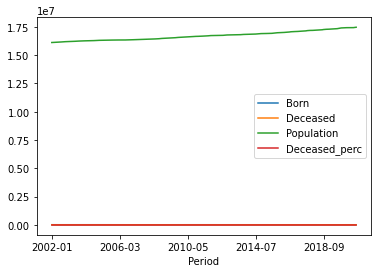

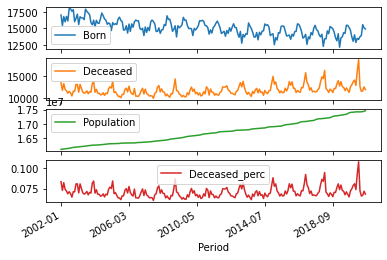

In [ ]:
population_nl.plot()
population_nl.plot(subplots=True)

In [ ]:
#TO DO: add CBS oversterfte (look for source)

### and then reproducting the coronadashboard
The data I use is the sources used formhet Coronadashbord of the Dutch government. https://coronadashboard.rijksoverheid.nl/
  
This contains:
*medical indicators*

In [ ]:
print("- number of positive tests")
# number of positive tests (https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/5f6bc429-1596-490e-8618-1ed8fd768427)
positive_tests = pd.read_json('https://data.rivm.nl/covid-19/COVID-19_aantallen_gemeente_per_dag.json')

In [ ]:
print('Date of report for RIVM positive tests data = ' + str(positive_tests.loc[0,'Date_of_report']))
positive_tests = positive_tests.drop(columns='Date_of_report')

In [ ]:
positive_tests = positive_tests.set_index(pd.PeriodIndex(positive_tests['Date_of_publication'], freq='d'))
positive_tests = positive_tests.drop(columns='Date_of_publication')
positive_tests['P'] = positive_tests.index.strftime('%Y-%m')
positive_tests = positive_tests.rename(index={'Date_of_publication':'date'})
positive_tests

In [ ]:
positive_tests_nl = positive_tests.sum(level='Date_of_publication')
positive_tests_nl['P'] = positive_tests_nl.index.strftime('%Y-%m')
positive_tests_nl

In [ ]:
pop_latest = population_nl.loc[population_nl['P'].max(),'Population']
pop_latest

In [ ]:
print(type(population_nl.P[0]))
print(type(positive_tests_nl.P[0]))

pd.merge_asof(positive_tests_nl,population_nl,left_on='P',right_on='P')

# Gemiddeld aantal positief geteste mensen per 100.000 inwoners
## Dit getal laat zien van hoeveel mensen gisteren per 100.000 inwoners gemeld is dat ze positief getest zijn en COVID-19 hebben.
positive_tests_nl['p100k'] = positive_tests_nl['Total_reported'] / population_nl.loc[if(positive_tests_nl['P'] > population_nl['P'].max()):
                                                                                     population_nl.loc[positive_tests_nl['P'],'Population']
                                                                                else:
                                                                                     positive_tests_nl['P']
                                                                                ,'Population'] * 100000


#pt_agg['mov_avg_p100k'] = np.average(pt_agg['']])
#np.mean(pt[len(pt.columns)-1].Total_reported)

In [ ]:
# Aantal positief geteste mensen
## Dit getal laat zien van hoeveel mensen gisteren gemeld is dat ze positief getest zijn en COVID-19 hebben.

In [ ]:
#Verdeling positief geteste mensen in Nederland
## per gemeente

## per veiligheidsregio



# TESTING BOKEH WITH OTHER DATA
pt_agg = pt.groupby(by=['Date_of_report'],as_index=False).sum()

q = figure(plot_width=800, plot_height=400, title="My Line Plot", x_axis_type="datetime")

q.multi_line(
    xs=[
        pt_agg['Date_of_report'],
        pt_agg['Date_of_report'],
        pt_agg['Date_of_report']
    ],
    ys=[
        pt_agg['Deceased'], 
        pt_agg['Hospital_admission'],
        pt_agg['Total_reported']
    ],
    color=viridis(len(pt_agg.columns)-1)
)

show(q)

In [ ]:
print("- Percentage positive tested of all tests done")
# https://www.rivm.nl/archief-weekrapportages-covid-19-in-nederland
pt_perc = tabula.read_pdf('https://www.rivm.nl/sites/default/files/2020-10/COVID-19_WebSite_rapport_wekelijks_20201013_1159_0.pdf', pages=29, guess=True, stream=True)
print(pt_perc)

## To DO:
## 1) extract data from latest pdf
## 2) scrape all pdfs for data to compare data thought time

In [ ]:
print("- number of infectious people")
# https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/097155aa-75eb-4caa-8ed3-4c6edb80467e
infected = pd.read_json('https://data.rivm.nl/covid-19/COVID-19_prevalentie.json')
print(infected.head())

In [ ]:
print("- R (reproductionnumber)")
# https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/ed0699d1-c9d5-4436-8517-27eb993eab6e
R = pd.read_json('https://data.rivm.nl/covid-19/COVID-19_reproductiegetal.json')
print(R.head())

In [ ]:
print("- hospital admissions per day")
# NICE https://www.databronnencovid19.nl/Bron?naam=Nationale-Intensive-Care-Evaluatie
hosp_nice = pd.read_json('https://stichting-nice.nl/covid-19/public/intake-count/')
print(hosp_nice.head())
# LCPS https://lcps.nu/datafeed/
hosp_lcps = pd.read_csv('https://lcps.nu/wp-content/uploads/covid-19.csv')
print(hosp_lcps.head())
# Dashbaord changed source data https://www.nu.nl/coronavirus/6083846/ministerie-meldde-maandenlang-veel-te-weinig-opnames-coronapatienten.html
# other sources: https://www.stichting-nice.nl/covid-19-op-de-zkh.jsp

In [ ]:
print("- icu admissions per day")
# url
ic_NICE_new_intake = pd.read_json('https://stichting-nice.nl/covid-19/public/new-intake/').T
ic_NICE_new_intake0 = pd.DataFrame()
for row in ic_NICE_new_intake[0]:
    ic_NICE_new_intake0 = ic_NICE_new_intake0.append(row, ignore_index=True)
print(ic_NICE_new_intake0)
ic_NICE_new_intake0['date'] = ic_NICE_new_intake['date']
ic_NICE_new_intake1 = pd.DataFrame()
for row in ic_NICE_new_intake[1]:
    ic_NICE_new_intake1 = ic_NICE_new_intake1.append(row, ignore_index=True)
ic_NICE_new_intake01 = pd.concat([ic_NICE_new_intake0,ic_NICE_new_intake1])
print(ic_NICE_new_intake01.head())
ic_NICE_new_intake_confirmed = pd.read_json('https://stichting-nice.nl/covid-19/public/new-intake/confirmed/')
#print(ic_NICE_new_intake_confirmed.head())
ic_NICE_intake_count = pd.read_json('https://stichting-nice.nl/covid-19/public/intake-count/')
#print(ic_NICE_intake_count.head())
print('IC data: 3 sources IMPORTED')
## To DO: conpare ic1 and ic2
#other sources: 

In [ ]:
ic_NICE_new_intake0

# SINGLE LINE TEST
# create a new plot (with a title) using figure
ic_new_intake0 = figure(plot_width=800, plot_height=400, x_axis_type="datetime", title="NICE new-intake")
# add a line renderer 
ic_new_intake0.line(
    ic_NICE_new_intake0['date'], 
    ic_NICE_new_intake0['value']
)
show(ic_new_intake0)

# SINGLE LINE TEST
# create a new plot (with a title) using figure
ic_new_intake_confirmed = figure(plot_width=800, plot_height=400, x_axis_type="datetime", title="NICE new-intake confirmed")
# add a line renderer 
ic_new_intake_confirmed.line(
    ic_NICE_new_intake_confirmed['date'], 
    ic_NICE_new_intake_confirmed['value']
)

# SINGLE LINE TEST
# create a new plot (with a title) using figure
ic_intake_count = figure(plot_width=800, plot_height=400, x_axis_type="datetime", title="NICE intake count")
# add a line renderer 
ic_intake_count.line(
    ic_NICE_intake_count['date'], 
    ic_NICE_intake_count['value']
)

## MULTIPLE LINE TEST
ic_all = figure(title="IC1 & IC_opnames_NICE", plot_width=800, plot_height=400, x_axis_type="datetime")

ic_all.multi_line([ic1.date, ic_opnames.date],
              [ic1.value, ic_opnames.value],
              color=viridis(3))

show(ic_new_intake)
show(ic_new_intake_confirmed)
show(ic_intake_count)
show(ic_all)

In [ ]:
## sources NICE for their website:
# /covid-19/public/zkh/global
# /covid-19/public/zkh/new-intake/
# /covid-19/public/zkh/intake-count/
# /covid-19/public/zkh/intake-cumulative/
# /covid-19/public/zkh/died-and-survivors-cumulative/
# /covid-19/public/zkh/age-distribution-died-and-survivors/
# /covid-19/public/zkh/age-distribution-status/
# /covid-19/public/zkh/behandelduur-distribution/
# /covid-19/public/zkh/behandelduur-distribution/
## TO DO: check which used and which to use extra.
## sources LCPS?
# https://lcps.nu/wp-content/uploads/
## Maybe scrape website to find more public data: https://scrapy.org/ OR https://www.crummy.com/software/BeautifulSoup/bs4/doc/

*early signs*

In [ ]:
print("- patient reporting covid symptoms at family doctor")
# https://www.nivel.nl/nl/nivel-zorgregistraties-eerste-lijn/nivel-zorgregistraties-eerste-lijn


In [ ]:
print("- sewagewate")
# https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/a2960b68-9d3f-4dc3-9485-600570cd52b9
sw = pd.read_json('https://data.rivm.nl/covid-19/COVID-19_rioolwaterdata.json')
print(sw.head())

*homes for elderly*

In [ ]:
print("- positive testst")
# from pdf. https://www.rivm.nl/documenten/wekelijkse-update-epidemiologische-situatie-covid-19-in-nederland

In [ ]:
print("- infected locations")
# from pdf. https://www.rivm.nl/documenten/wekelijkse-update-epidemiologische-situatie-covid-19-in-nederland

In [ ]:
print("- number deseased")
# from pdf. https://www.rivm.nl/documenten/wekelijkse-update-epidemiologische-situatie-covid-19-in-nederland

**metadata**

In [ ]:
print("- municipalities in Netherlands")
## https://www.cbs.nl/nl-nl/onze-diensten/methoden/classificaties/overig/gemeentelijke-indelingen-per-jaar/indeling%20per%20jaar/gemeentelijke-indeling-op-1-januari-2020
municipality = pd.read_excel('https://www.cbs.nl/-/media/_excel/2020/03/gemeenten-alfabetisch-2020.xlsx')
print(municipality.head())
# aantallen per gemeente: https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/5f6bc429-1596-490e-8618-1ed8fd768427


### missing data, i would like to calculate of collect
- covid numbers relitive to all data
- deseased for whole country (possible source: https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/1c0fcd57-1102-4620-9cfa-441e93ea5604)

### more data

- Karakteristieken elke geteste persoon: https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/2c4357c8-76e4-4662-9574-1deb8a73f724?tab=relations
- https://data.rivm.nl

In [ ]:
#check data collection
from pivottablejs import pivot_ui
from IPython.display import HTML

df_to_check = ic1

pivot_ui(df_to_check, outfile_path='pivottablejs.html')
HTML('pivottablejs.html')